# Kickstarter: Exploration & Prediction
By:
* Cen Liang
* Mahmoud Belhaj
* Jonas Cristens

### Description:



Kickstarter Is an American public-benefit corporation based in Brooklyn, New York, that maintains a global crowdfunding platform focused on creativity The company's stated mission is to "help bring creative projects to life". Kickstarter has reportedly received more than $1.9 billion in pledges from 9.4 million backers to fund 257,000 creative projects, such as films, music, stage shows, comics, journalism, video games, technology and food-related projects.

People who back Kickstarter projects are offered tangible rewards or experiences in exchange for their pledges. This model traces its roots to subscription model of arts patronage, where artists would go directly to their audiences to fund their work.


### Columns:

ID
* internal kickstarter id

name
* name of project - A project is a finite work with a clear goal that you’d like to bring to life. Think albums, books, or films.

category
* category

main_category
* category of campaign

currency
* currency used to support

deadline
* deadline for crowdfunding

goal
* fundraising goal - The funding goal is the amount of money that a creator needs to complete their project.

launched
* date launched

pledged
* amount pledged by "crowd"

state
* Current condition the project is in

backers
* number of backers

country
* country pledged from

usd pledged
* amount of money pledged

Goal
* amount in USD 

### Load the required packages

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve

from scikitplot.metrics import plot_confusion_matrix
from scikitplot.estimators import plot_feature_importances
from scikitplot.estimators import plot_learning_curve
from scikitplot.cluster import plot_elbow_curve
from scikitplot.metrics import plot_silhouette
from scikitplot.decomposition import plot_pca_component_variance
from scikitplot.metrics import plot_roc

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.neural_network import MLPClassifier
from scipy import stats
import textstat

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

### Read the Kickstarter projects file 201801 csv and parse the dates and change the categorical columns to categories

In [2]:
df = pd.read_csv('ks-projects-201801.csv', parse_dates = ['launched', 'deadline'], index_col = 'ID')
df = df.astype({"category": 'category',
                "main_category": 'category', 
                "currency": 'category', 
                'state' : 'category', 
                'country' : 'category',
               })
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Check if there is data missing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null category
main_category       378661 non-null category
currency            378661 non-null category
deadline            378661 non-null datetime64[ns]
goal                378661 non-null float64
launched            378661 non-null datetime64[ns]
pledged             378661 non-null float64
state               378661 non-null category
backers             378661 non-null int64
country             378661 non-null category
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: category(5), datetime64[ns](2), float64(5), int64(1), object(1)
memory usage: 31.1+ MB


There are 3797 missing values for the column `usd_plegded` and 4 missing for the column `name`, there in total 378661 rows and 16 columns. 

`usd_plegded` is a conversion made by KS which sometime is the `usd_pledged_real` or sometimes a calculation which we don't understand.

In [4]:
df.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


The standard deviation in goal, pledged, usd_pledged, usd_pledged_real and usd_goal_real is high. This indicates
that the data is spread out.

### Check the data types

In [5]:
df.dtypes

name                        object
category                  category
main_category             category
currency                  category
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                     category
backers                      int64
country                   category
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

The dtypes are correct now we can calculate the difference in days between `launced` and `deadline`.

### Number of words and characters in name

Calculate the lenght of the name of the Kickstarter project.

In [6]:
df['number_of_chars'] = df['name'].str.len()

Split the name of the Kickstarter project based on a space and count how many splits there are.

In [7]:
df['number_of_words'] = df['name'].apply(lambda x: len(str(x).split()))

### Syllable count

In [8]:
df["syllable_count"] = df["name"].apply(lambda x: textstat.syllable_count(str(x)))

### Launched dates

Calculate the number of week, month and weekday when the campaign was launched.

In [9]:
df["launched_week"] = df["launched"].dt.week

df["launched_month"] = df["launched"].dt.month

df["launched_day"] = df["launched"].dt.weekday

### Days to collect

Calculate the number of days difference between the deadline and launch date.

In [10]:
df['days_to_collect'] = (df['deadline'] - df['launched']).dt.days
df['days_to_collect'].head(5)

ID
1000002330    58
1000003930    59
1000004038    44
1000007540    29
1000011046    55
Name: days_to_collect, dtype: int64

### Average amount per day needed to reach the goal

In [11]:
# replace the inf values with 0 (0/something) = np.inf) 
df['usd_needed_per_day'] = (df['usd_goal_real'] / df['days_to_collect']).replace([np.inf, -np.inf], 0)

### What are the different Kickstarter states?

In [12]:
df['state'].unique()

[failed, canceled, successful, live, undefined, suspended]
Categories (6, object): [failed, canceled, successful, live, undefined, suspended]

We define 
* `failed`, `canceled`, `undefined` and `suspended` as failed.
* `successful` as success.
* `live` not relevant ==> will be deleted since our goal is to predict if it will fail or succeed

In [13]:
conditions = [df['state'].isin(['failed', 'canceled', 'undefined', 'suspended']),
             df['state'].isin(['successful'])]
df['cln_state'] = np.select(conditions, [-1, 1])

### Calculate the average contribution per backer

In [14]:
# replace the inf values with 0 (0/something) = np.inf) 
df['usd_per_backer'] = (df['usd_goal_real'] / df['backers']).replace([np.inf, -np.inf], 0)

### Average `usd_needed_per_day` per state

In [15]:
usd_pd = df.groupby('state')['usd_needed_per_day'].mean()

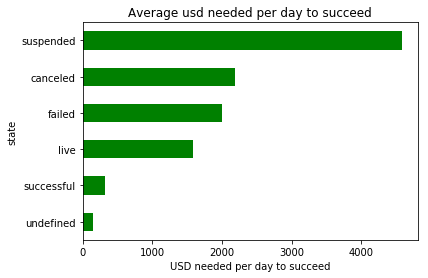

In [16]:
ax = usd_pd.sort_values().plot.barh(color='green', title='Average usd needed per day to succeed')
ax.set_xlabel('USD needed per day to succeed');

In [17]:
stats.ttest_ind(df.loc[df['state']=='successful' ,'usd_needed_per_day'].values,
                df.loc[df['state']=='canceled' ,'usd_needed_per_day'].values)

Ttest_indResult(statistic=-15.249079028640972, pvalue=1.8067227497003203e-52)

The difference between `canceled` and `successful` is significantly different for the column `usd_needed_per_day`. So the `usd_needed_per_day` really makes a different.

### Does the length of the project make a difference (0 - 30 days and 31 - 60 days)

In [18]:
# add 2 bins ranging from 0 - 30 (short) and 31 - 60 (long)
df['days_bins'] = pd.cut(df['days_to_collect'], 
                         bins = [0,30,60], 
                         labels=['short', 'long'])

# add 4 bins ranging from 0 - 100 (small), 101 - 500 (medium), 501 - 1000 (big), 1001 - 10000 (huge)
df['usd_bins_per_day'] = pd.cut(df['usd_needed_per_day'], 
                                bins = [0,100, 500, 1000, 10_000], 
                                labels = ['small', 'medium', 'big', 'huge'])

In [19]:
# caculate the number of occurences by 'state', 'days_bins', 'usd_bins_per_day'
length_diff = df.groupby(['state', 'days_bins', 'usd_bins_per_day'])['goal'].count()

In [20]:
# caculate the sum of occurences grouped by usd_bins_per_day for the period short
sum_count_short = length_diff[['failed', 'successful']]\
    .xs('short', level=1)\
    .reset_index()\
    .groupby('usd_bins_per_day')\
    .sum()

# caculate the sum of occurences grouped by usd_bins_per_day for the period long
sum_count_long = length_diff[['failed', 'successful']]\
    .xs('long', level=1).reset_index()\
    .groupby('usd_bins_per_day')\
    .sum()

In [21]:
# caculate the sum of successful occurences grouped by usd_bins_per_day for the period short
sum_count_short_succ = length_diff[['successful']]\
    .xs('short', level=1)\
    .reset_index()\
    .groupby('usd_bins_per_day')\
    .sum()

# caculate the sum of successful occurences grouped by usd_bins_per_day for the period long
sum_count_long_succ = length_diff[['successful']]\
    .xs('long', level=1)\
    .reset_index()\
    .groupby('usd_bins_per_day')\
    .sum()

In [22]:
# calculate the probability of being successful short term
succ_short_prob = sum_count_short_succ / sum_count_short
# calculate the probability of being successful long term
succ_long_prob = sum_count_long_succ / sum_count_long

In [23]:
# rename the columns to short and long
succ_short_prob = succ_short_prob.rename(columns = {'goal':'short'})
succ_long_prob = succ_long_prob.rename(columns = {'goal':'long'})

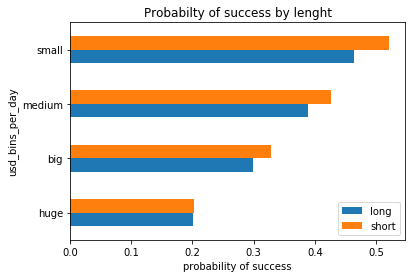

In [24]:
# plot the probability of being successful for short and long term per usd_bins_per_day
ax = pd.concat([succ_long_prob, succ_short_prob], axis=1)\
    .sort_values(by='short')\
    .plot\
    .barh(title = 'Probabilty of success by lenght')

ax.set_xlabel('probability of success');

### Check the probability of success per `main_category`

In [25]:
# caculate the probability of being successful per main_category
proba_state_main = df.groupby(['main_category', 'state'])['launched'].count()\
    / \
    df.groupby('main_category')['launched'].count()

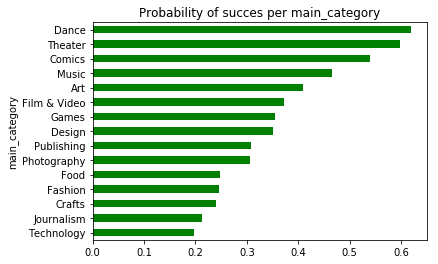

In [26]:
proba_state_main.xs('successful', level=1)\
    .sort_values(ascending=True)\
    .plot\
    .barh(color='green', title='Probability of succes per main_category');

### Top 5 most successful projects (the onces with most USD money pledged)

In [27]:
df.loc[df['state'] == 'successful'].sort_values(by='usd_pledged_real', ascending=False).iloc[:5]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,...,syllable_count,launched_week,launched_month,launched_day,days_to_collect,usd_needed_per_day,cln_state,usd_per_backer,days_bins,usd_bins_per_day
ID,,,,,,,,,,,,,,,,,,,,,
1799979574,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-03-28,500000.0,2015-02-24 15:44:42,20338986.27,successful,78471,...,13,9,2,1,31,16129.032258,1,6.371781,long,NaN
342886736,COOLEST COOLER: 21st Century Cooler that's Act...,Product Design,Design,USD,2014-08-30,50000.0,2014-07-08 10:14:37,13285226.36,successful,62642,...,16,28,7,1,52,961.538462,1,0.798187,long,big
2103598555,"Pebble 2, Time 2 + All-New Pebble Core",Product Design,Design,USD,2016-06-30,1000000.0,2016-05-24 15:49:52,12779843.49,successful,66673,...,11,21,5,1,36,27777.777778,1,14.998575,long,NaN
545070200,Kingdom Death: Monster 1.5,Tabletop Games,Games,USD,2017-01-08,100000.0,2016-11-25 06:01:41,12393139.69,successful,19264,...,6,47,11,4,43,2325.581395,1,5.191030,long,huge
506924864,Pebble: E-Paper Watch for iPhone and Android,Product Design,Design,USD,2012-05-19,100000.0,2012-04-11 06:59:04,10266845.74,successful,68929,...,10,15,4,2,37,2702.702703,1,1.450768,long,huge


### Top 5 most successful where `goal > 100` projects (the onces with the highest ratio `usd_pledged_real` / `goal`)

In [28]:
df['goal_ratio'] = df['usd_pledged_real'] / df['goal']

In [29]:
df.loc[(df['state'] == 'successful') & (df['goal']>100)]\
    .sort_values(
        by='goal_ratio', 
        ascending=False)\
    .iloc[:5]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,...,launched_week,launched_month,launched_day,days_to_collect,usd_needed_per_day,cln_state,usd_per_backer,days_bins,usd_bins_per_day,goal_ratio
ID,,,,,,,,,,,,,,,,,,,,,
1176482851,TREVOR HALL presents... The Fruitful Darkness,Music,Music,USD,2017-09-06,108.0,2017-08-07 20:17:39,137570.93,successful,2254,...,32,8,0,29,3.724138,1,0.047915,short,small,1273.804907
1955357092,Exploding Kittens,Tabletop Games,Games,USD,2015-02-20,10000.0,2015-01-20 19:00:19,8782571.99,successful,219382,...,4,1,1,30,333.333333,1,0.045583,short,medium,878.257199
902047561,YOGA : TIME | The best way to practice yoga,Apps,Technology,USD,2015-03-11,108.0,2015-01-16 13:10:17,86944.00,successful,1620,...,3,1,4,53,2.037736,1,0.066667,long,small,805.037037
1538025770,MC YOGI: ONLY LOVE IS REAL,Hip-Hop,Music,USD,2014-12-20,108.0,2014-11-05 01:46:40,86506.00,successful,1440,...,45,11,2,44,2.454545,1,0.075000,long,small,800.981481
968166384,Modern Map Art Prints,Graphic Design,Design,GBP,2017-09-23,250.0,2017-08-24 01:17:10,94711.00,successful,1942,...,34,8,3,29,11.542069,1,0.172358,short,small,507.228640


### Most successful projects over 100 dollar goal  by main_category

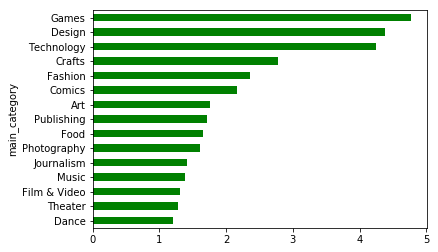

In [30]:
df[(df['state'] == 'successful') & (df['goal']>100)]\
    .groupby('main_category')['goal_ratio']\
    .mean()\
    .sort_values()\
    .plot.barh(color='green')

### Evolution of succes ratio over time

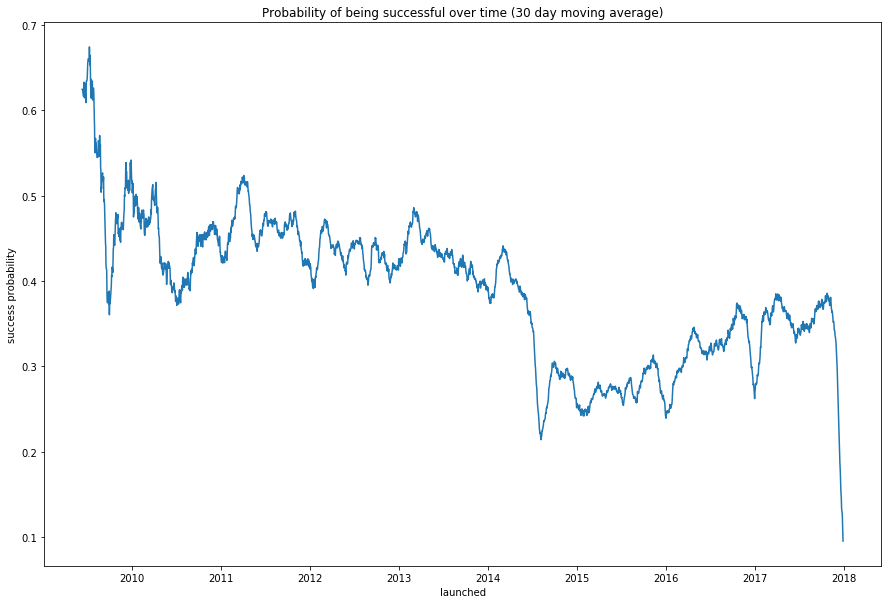

In [31]:
# caculate the number of launches per day
total_time = df.groupby([df['launched'].dt.date])['name'].count()
# caculate the number of launches per day and per state
over_time = df.groupby([df['launched'].dt.date, df['state']])['name'].count()
# caculate the probability of being successful over time
per_suc_over_time = (over_time/total_time).xs('successful', level=1)
# plot the rolling 30 day mean of the success rate
ax = per_suc_over_time.rolling(30).mean().plot(figsize = (15,10))
ax.set_ylabel('success probability')
plt.title('Probability of being successful over time (30 day moving average)');

### Plot the distribution of the numerical variables

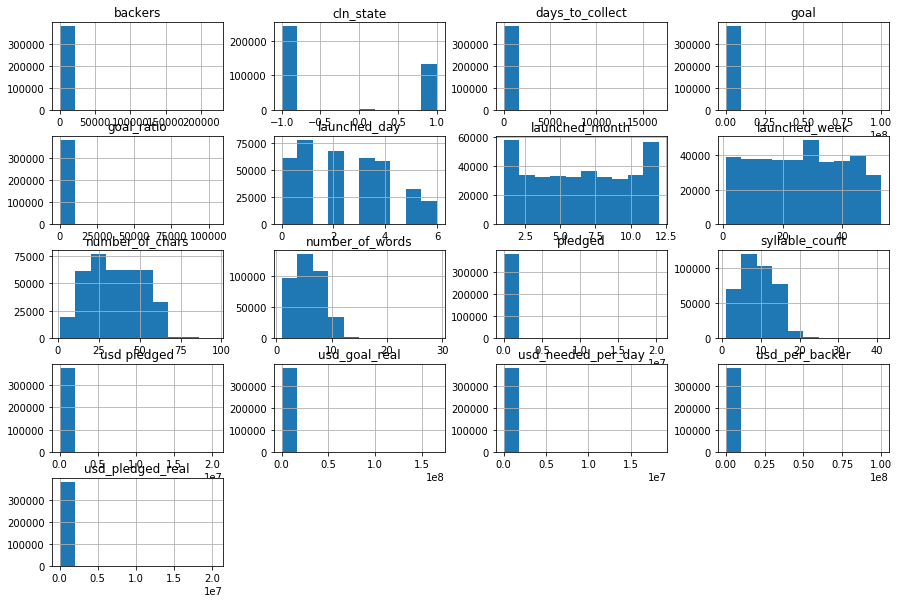

In [32]:
df.hist(figsize=(15,10));

The difference between the average and max value is huge. This means that there are serious outliers which we decided to delete (this will be done in the next step). The outliers will be removed by removing the data which is 3 or more standard deviations away from the mean.

In [33]:
cols = ['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real',
       'usd_goal_real']

In [34]:
df[cols] = df[cols].mask((df[cols] - df[cols].mean()).abs() > 3 * df[cols].std())
df = df.dropna()

In [35]:
# remove where cln_state = 0
df = df[df['cln_state'] !=0 ]

Now all the data which is more than 3 standard devations away from the mean is removed.

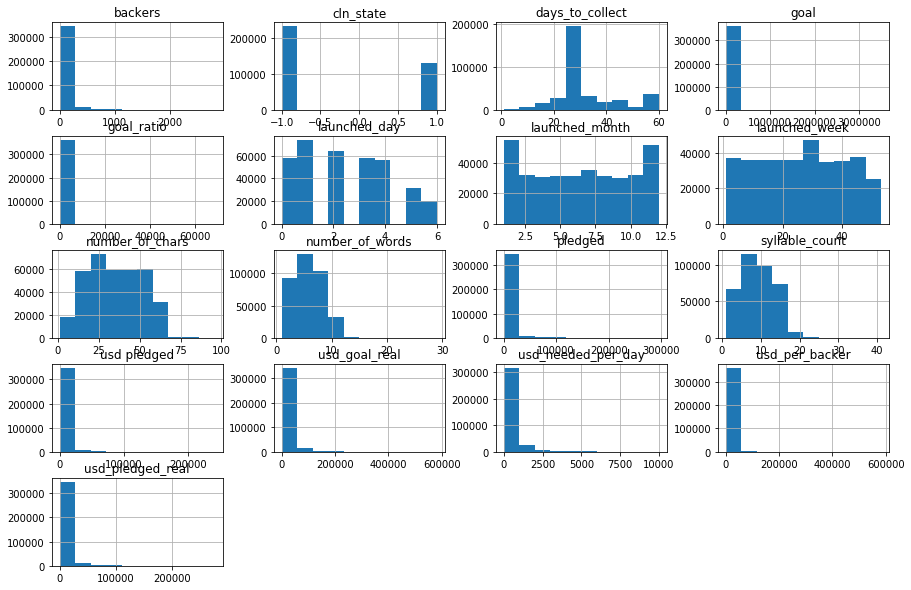

In [36]:
df.hist(figsize=(15,10));

### Diff mean category goal

In [37]:
# caculate the mean goal per category
mean_cat_goal = df.groupby('category')['goal'].mean().rename('mean_cat_goal')
# caculate the mean goal per main_category
mean_main_cat_goal = df.groupby('main_category')['goal'].mean().rename('mean_main_cat_goal')

In [38]:
df = df.merge(mean_cat_goal.to_frame(), how = 'left', left_on='category', right_on=mean_cat_goal.index)
df = df.merge(mean_main_cat_goal.to_frame(), how = 'left', left_on='main_category', \
              right_on=mean_main_cat_goal.index)

In [39]:
df["diff_mean_category_goal"] = df["mean_cat_goal"] - df["goal"]
df["diff_mean_main_category_goal"] = df["mean_main_cat_goal"] - df["goal"]

In [40]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,...,usd_needed_per_day,cln_state,usd_per_backer,days_bins,usd_bins_per_day,goal_ratio,mean_cat_goal,mean_main_cat_goal,diff_mean_category_goal,diff_mean_main_category_goal
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0.0,...,26.447414,-1,0.000000,long,small,0.000000,5353.075567,10752.078520,4353.075567,9752.078520
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15.0,...,508.474576,-1,2000.000000,long,big,0.080700,27577.975505,20826.147106,-2422.024495,-9173.852894
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3.0,...,1022.727273,-1,15000.000000,long,huge,0.004889,27577.975505,20826.147106,-17422.024495,-24173.852894
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1.0,...,172.413793,-1,5000.000000,short,medium,0.000200,11893.370601,9381.239290,6893.370601,4381.239290
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14.0,...,354.545455,-1,1392.857143,long,medium,0.065795,25095.829953,20826.147106,5595.829953,1326.147106


### Check the unique states

In [41]:
df['cln_state'].unique()

array([-1,  1])

### Drop the columns which we can't use for the prediction

In [42]:
df = df.drop(columns=['name', 
                      'deadline', 
                      'launched', 
                      'state', 
                      'pledged',
                      'usd pledged', 
                      'usd_pledged_real', 
                      'usd_per_backer',
                      'backers',
                      'goal_ratio'
                     ])

### Standardization the data

Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

This is why we standerdize the data. We choose to use the PowerTransFormer from sklearn. After apply PCA this yields less components than just normalizing the data. (188 components using PowerTransFormer vs 208 using normalization).

PowerTransFromer method tries to model the continious numerical features as gaussian distriubtion when they are skewed.

Ref: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization

In [43]:
from sklearn.preprocessing import PowerTransformer

cols = df.select_dtypes([np.number]).drop(columns = 'cln_state').columns

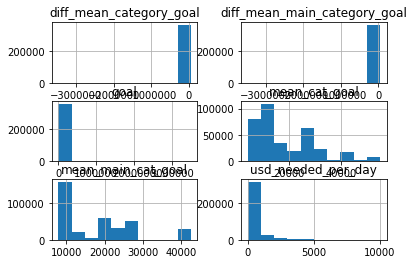

In [44]:
df[['goal', 'usd_needed_per_day'
    , 'mean_cat_goal', 'mean_main_cat_goal'\
    , 'diff_mean_category_goal', 'diff_mean_main_category_goal']].hist();

In [45]:
trans = PowerTransformer().fit_transform(X = df[['goal', 'usd_needed_per_day'\
                                                 , 'mean_cat_goal', 'mean_main_cat_goal'\
                                                 , 'diff_mean_category_goal', 'diff_mean_main_category_goal']])

In [46]:
trans_df = pd.DataFrame(trans, columns=['goal', 'usd_needed_per_day', 'mean_cat_goal', 'mean_main_cat_goal'\
                                        , 'diff_mean_category_goal', \
                                        'diff_mean_main_category_goal'], index=df.index)

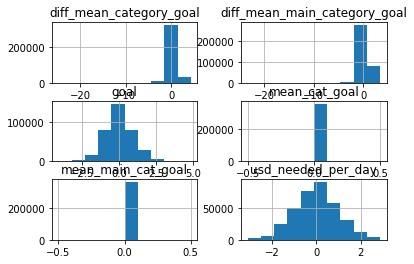

In [47]:
trans_df.hist();

### Dummies & PCA

Get the dummies of the categorical columns. Keeping them as continious features doesn't make sense since the correlation between then would mean nothing. e.g. month = 12 and y = 1 which would be a high correlation vs month = 1 and y = 1 would be a inverse correlation. This applies to all the categorical columns.

In [48]:
months = pd.get_dummies(df['launched_month'], drop_first=True)
days = pd.get_dummies(df['launched_day'], drop_first=True)
weeks = pd.get_dummies(df['launched_week'], drop_first=True)
chars = pd.get_dummies(df['number_of_chars'], drop_first=True)
words = pd.get_dummies(df['number_of_words'], drop_first=True)
days_to_col = pd.get_dummies(df['days_to_collect'], drop_first=True)
currency = pd.get_dummies(df['currency'], drop_first=True)
main_cat = pd.get_dummies(df['main_category'], drop_first=True)
cat = pd.get_dummies(df['category'], drop_first=True)
days_bins = pd.get_dummies(df['days_bins'], drop_first=True)
usd_bins_per_day = pd.get_dummies(df['usd_bins_per_day'], drop_first=True)
syllable_count = pd.get_dummies(df['syllable_count'], drop_first=True)

Merge the dummies and the standerdized features.

In [49]:
df_dums = pd.concat([weeks, months, days, chars, words, days_to_col, currency, \
                      main_cat, cat, trans_df, syllable_count \
          , usd_bins_per_day, days_bins], axis=1)

In [50]:
X = df_dums
y = df['cln_state']

The dataset is imbalanced as you can see below. That's why we will apply oversampling to equal the classes out.

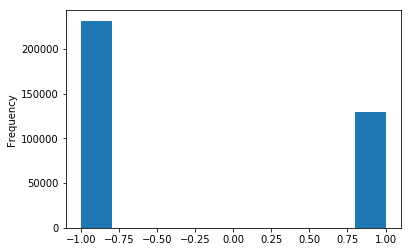

In [51]:
df['cln_state'].plot.hist();

Apply oversampling because the dataset is imbalanced.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train, y_train = RandomOverSampler(0.775).fit_resample(X_train, y_train)

In [53]:
X_train.shape

(275162, 477)

Since we have 477 features we are going to apply PCA to reduce the number of dimensions and keep as much variance as possible. We decided to put the threshold at 99% (keep 99% of the variance in the data). 

### PCA

In [54]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

We keep 99% percent of the variance in the data with 286 components.

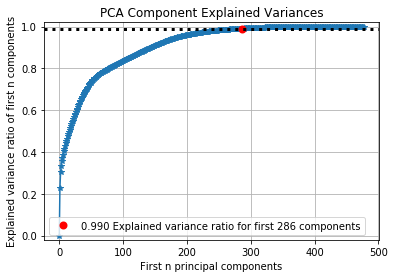

In [55]:
plot_pca_component_variance(pca, target_explained_variance=0.99)

In [56]:
pca = PCA(n_components= 0.99)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [57]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### LogisticRegression

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [60]:
clf = LogisticRegression(C=0.01, n_jobs=-1)

In [61]:
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.68 (+/- 0.00)


In [63]:
y_pred = clf.predict(X_test)

In [64]:
accuracy_score(y_test, y_pred)

0.6925994294344688

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.76      0.75      0.76     76354
           1       0.57      0.58      0.58     42826

   micro avg       0.69      0.69      0.69    119180
   macro avg       0.67      0.67      0.67    119180
weighted avg       0.69      0.69      0.69    119180



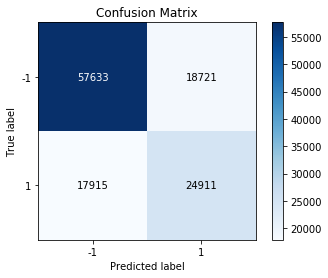

In [84]:
plot_confusion_matrix(y_test, y_pred);

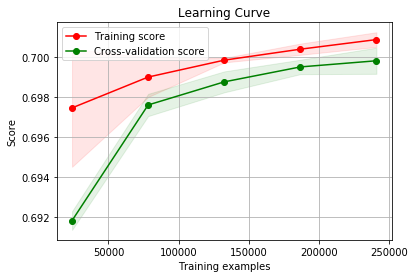

In [67]:
plot_learning_curve(clf, X, y, n_jobs=-1)

#### Grid search with logistic regression

In [713]:
from sklearn.model_selection import GridSearchCV

grid = {
    "C":np.logspace(-3,1,5), 
    "penalty":["l1","l2"]
}

In [714]:
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,grid, cv=10, n_jobs = -1)
logreg_cv.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

### ExtraTreeClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train, y_train = RandomOverSampler(0.90).fit_resample(X_train, y_train)

In [ ]:
pca = PCA(n_components= 0.99)
pca.fit(X_train)

In [ ]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#### Train the model

In [ ]:
clf = ExtraTreesClassifier(min_samples_split=200, max_depth=30,  n_jobs=-1)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
plot_feature_importances(clf, feature_names=X.columns.values, max_num_features=10, ax=ax)

In [ ]:
plot_learning_curve(clf, X, y, n_jobs=-1)

### SGDClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train, y_train = RandomOverSampler(0.778).fit_resample(X_train, y_train)

In [ ]:
pca = PCA(n_components= 0.99)
pca.fit(X_train)

In [ ]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#### Train the model

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
clf = SGDClassifier(n_jobs=-1)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
plot_learning_curve(clf, X, y, n_jobs=-1)

In [ ]:
grid = {
    "loss":['hinge'], 
    "penalty":["l2"],
    'alpha': np.logspace(-6,-3,7)
}

clf = SGDClassifier(n_jobs=-1)
logreg_cv = GridSearchCV(clf,grid, cv=3, n_jobs = -1)
logreg_cv.fit(X_train, y_train)

In [ ]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

### RBFSampler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train, y_train = RandomOverSampler(0.81).fit_resample(X_train, y_train)

In [ ]:
pca = PCA(n_components= 0.99)
pca.fit(X_train)

In [ ]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

In [ ]:
rbf_feature = RBFSampler(gamma=0.001, n_components=1000, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
clf = SGDClassifier()
clf.fit(X_features, y_train)   

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
X_features_t = rbf_feature.fit_transform(X_test)
y_pred = clf.predict(X_features_t)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
plot_learning_curve(clf, X, y, n_jobs=-1)

#### RBFSampler gridsearch

In [120]:
from sklearn.pipeline import Pipeline

In [134]:
grid = {
    "rbfsampler__n_components": np.linspace(188,1000,5, dtype=int),
    'rbfsampler__gamma': np.logspace(-3,3,5)
}

In [136]:
rbf_feature = RBFSampler(random_state=1)
clf = SGDClassifier(alpha = 0.001, loss = 'hinge', penalty = 'l2')

rbf_clf = Pipeline(steps=[('rbfsampler', rbf_feature), ('sgd', clf)])  

logreg_cv = GridSearchCV(rbf_clf, grid, cv=3, n_jobs = -1)
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('rbfsampler', RBFSampler(gamma=1.0, n_components=100, random_state=1)), ('sgd', SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optim..._state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rbfsampler__n_components': array([ 188,  391,  594,  797, 1000]), 'rbfsampler__gamma': array([1.00000e-03, 3.16228e-02, 1.00000e+00, 3.16228e+01, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [137]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'rbfsampler__gamma': 0.03162277660168379, 'rbfsampler__n_components': 1000}
accuracy : 0.6504894517494265


### Neural Network

In [62]:
clf = MLPClassifier(hidden_layer_sizes=(189,2), learning_rate='adaptive', warm_start=True)

In [63]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(189, 2), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [66]:
y_pred = clf.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred)

0.6409602880191115

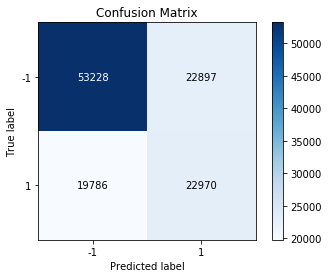

In [68]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
plot_learning_curve(clf, X, y, n_jobs=-1)

### GradientBoostingClassifier

In [543]:
from sklearn.ensemble import GradientBoostingClassifier

In [544]:
clf = GradientBoostingClassifier()

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
plot_learning_curve(clf, X, y, n_jobs=-1)

### XGBoost

In [90]:
import xgboost as xgb

In [92]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
plot_learning_curve(xgb_model, X, y, n_jobs=-1)